In [74]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score

## Load data

In [75]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
# y_test = np.load("y_test.npy")

In [76]:
# 7000 data with 300 features
print(x_train.shape)

(7000, 300)


In [77]:
# It's a binary classification problem 
print(np.unique(y_train))

[0 1]


## Question 1
K-fold data partition: Implement the K-fold cross-validation function. Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [78]:
def cross_validation(x_train, y_train, k=5):
    
    kFold = []

    left = len(x_train) % k
    startVal = 0
    endVal = 0
    # get the data and shuffle before partition
    index = np.arange(len(x_train))
    np.random.seed(5)
    np.random.shuffle(index)
    # run through every fold
    for i in range(k):
        # calculate the index used for validation in each fold
        foldLength = len(x_train) // k
        if left > 0: # add one more space to the current fold if still spaces not classified
            foldLength += 1
            left -= 1
        endVal = startVal + foldLength
        # find the index used for training in each fold
        trainIndex = list(range(0, startVal)) + list(range(endVal, len(x_train)))
        # store the splits of data
        kFold.append([index[trainIndex], index[range(startVal, endVal)]])
        startVal += foldLength

    return kFold 

In [79]:
kfold_data = cross_validation(x_train, y_train, k=10)
assert len(kfold_data) == 10 # should contain 10 fold of data
assert len(kfold_data[0]) == 2 # each element should contain train fold and validation fold
assert kfold_data[0][1].shape[0] == 700 # The number of data in each validation fold should equal to training data divieded by K

## example

In [80]:
from sklearn.model_selection import KFold

X = np.arange(20)
kf = KFold(n_splits=5, shuffle=True)
kfold_data= []
for i, (train_index, val_index) in enumerate(kf.split(X)):
    print("Split: %s, Training index: %s, Validation index: %s" % (i+1, train_index, val_index))
    kfold_data.append([train_index, val_index])

Split: 1, Training index: [ 0  2  3  4  5  6 10 11 12 13 14 15 16 17 18 19], Validation index: [1 7 8 9]
Split: 2, Training index: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 16 18 19], Validation index: [12 14 15 17]
Split: 3, Training index: [ 1  3  4  5  6  7  8  9 10 11 12 14 15 17 18 19], Validation index: [ 0  2 13 16]
Split: 4, Training index: [ 0  1  2  4  7  8  9 10 11 12 13 14 15 16 17 19], Validation index: [ 3  5  6 18]
Split: 5, Training index: [ 0  1  2  3  5  6  7  8  9 12 13 14 15 16 17 18], Validation index: [ 4 10 11 19]


In [81]:
assert len(kfold_data) == 5 # should contain 5 fold of data
assert len(kfold_data[0]) == 2 # each element should contains index of training fold and validation fold
assert kfold_data[0][1].shape[0] == 4 # The number of data in each validation fold should equal to training data divieded by K

## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C” and “gamma” to find the best parameters by cross-validation.

In [82]:
kfold_data = cross_validation(x_train, y_train, k=5)
bestScore = 0
best_parameters = {} # a dictionary for saving best C and gamma
allScore = [] # for plotting

# search some outlier tolerance (bigger C, lower tolerance)
for C in [0.1, 1, 10, 100, 1000, 10000, 100000]:
    valScore = []
    # search some range of influence (bigger gamma, smaller range)
    for gamma in [0.000001 ,0.00001, 0.0001, 0.001, 0.01]:
        totalScore = 0
        # train and predict with each fold
        for train, val in kfold_data:
            clf = SVC(C=C, kernel='rbf', gamma=gamma) # rbf works like weighted nearest neighbor
            clf.fit(x_train[train], y_train[train])
            y_pred = clf.predict(x_train[val])
            totalScore += accuracy_score(y_train[val], y_pred)
        avgScore = totalScore / 5
        valScore.append(avgScore)
        # update the best score
        if avgScore > bestScore:
            bestScore = avgScore
            best_parameters = {"C": C, "gamma": gamma}
    # record for plotting
    allScore.append(valScore)

In [83]:
print(best_parameters)

{'C': 1, 'gamma': 0.0001}


## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. And the color represents the average score of validation folds
You reults should be look like this reference image below ![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

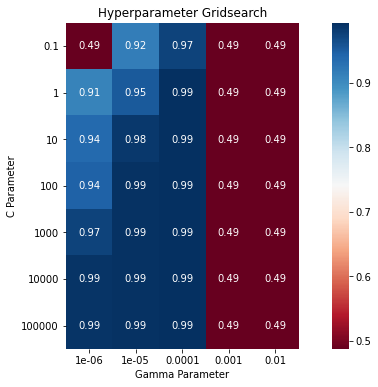

In [84]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.imshow(allScore, interpolation='nearest', cmap=plt.cm.RdBu)
allScore = np.array(allScore)
for g in range(allScore.shape[0]):
    for c in range(allScore.shape[1]):
        plt.text(c, g, '%.2f' % allScore[g][c], horizontalalignment='center', verticalalignment='center', color='white')
plt.title('Hyperparameter Gridsearch')
plt.xlabel('Gamma Parameter')
plt.ylabel('C Parameter')
c = [0.1, 1, 10, 100, 1000, 10000, 100000]
gamma = [0.000001 ,0.00001, 0.0001, 0.001, 0.01]
plt.xticks(np.arange(len(gamma)), gamma)
plt.yticks(np.arange(len(c)), c)
plt.colorbar().outline.set_visible(False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set.

In [85]:
best_model = SVC(C=1, kernel='rbf', gamma=0.0001)
best_model.fit(x_train,y_train)
y_pred = best_model.predict(x_test)
print("Accuracy score: ", accuracy_score(y_pred, y_test))

NameError: name 'y_test' is not defined